<a href="https://colab.research.google.com/github/Samia1925/BestCropOfDistrictToCultivate/blob/main/BestCropOfDistrictToCultivate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
try:
    import optuna
except ImportError:
    print("Optuna not installed. Installing now...")
    !pip install optuna
    !pip install optuna --user
    import optuna
import warnings
warnings.filterwarnings('ignore')

Optuna not installed. Installing now...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.5 MB/s eta 0:00:00


# Load the dataset



> source>>
https://data.mendeley.com/datasets/ncw2vbcgnk/2




In [2]:
df = pd.read_csv('crop_yield.csv')


print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nDescriptive Statistics:")
print(df.describe())

Dataset Shape: (19689, 10)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             19689 non-null  object 
 1   Crop_Year        19689 non-null  int64  
 2   Season           19689 non-null  object 
 3   State            19689 non-null  object 
 4   Area             19689 non-null  float64
 5   Production       19689 non-null  int64  
 6   Annual_Rainfall  19689 non-null  float64
 7   Fertilizer       19689 non-null  float64
 8   Pesticide        19689 non-null  float64
 9   Yield            19689 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.5+ MB

Descriptive Statistics:
          Crop_Year          Area    Production  Annual_Rainfall  \
count  19689.000000  1.968900e+04  1.968900e+04     19689.000000   
mean    2009.127584  1.799266e+05  1.643594e+07      1437.755177   
std   

# Check for missing values

In [4]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Crop               0
Crop_Year          0
Season             0
State              0
Area               0
Production         0
Annual_Rainfall    0
Fertilizer         0
Pesticide          0
Yield              0
dtype: int64


# Filter out invalid data

In [5]:
df = df[df['Yield'] > 0]
df = df[df['Production'] > 0]
df = df[df['Area'] > 0]

# Unique values in categorical columns

In [6]:
print("\nUnique Crops Count:", len(df['Crop'].unique()), "crops")
print("\nUnique Crops:", df['Crop'].unique())
print("\nUnique Seasons:", df['Season'].unique())
print("\nUnique States:", df['State'].unique())


Unique Crops Count: 55 crops

Unique Crops: ['Arecanut' 'Arhar/Tur' 'Castor seed' 'Coconut' 'Cotton(lint)'
 'Dry chillies' 'Gram' 'Jute' 'Linseed' 'Maize' 'Mesta' 'Niger seed'
 'Onion' 'Other Rabi pulses' 'Potato' 'Rapeseed & Mustard' 'Rice'
 'Sesamum' 'Small millets' 'Sugarcane' 'Sweet potato' 'Tapioca' 'Tobacco'
 'Turmeric' 'Wheat' 'Bajra' 'Black pepper' 'Cardamom' 'Coriander' 'Garlic'
 'Ginger' 'Groundnut' 'Horse-gram' 'Jowar' 'Ragi' 'Cashewnut' 'Banana'
 'Soyabean' 'Barley' 'Khesari' 'Masoor' 'Moong(Green Gram)'
 'Other Kharif pulses' 'Safflower' 'Sannhamp' 'Urad'
 'Peas & beans (Pulses)' 'Sunflower' 'other oilseeds' 'Other Cereals'
 'Cowpea(Lobia)' 'Oilseeds total' 'Guar seed' 'Other Summer Pulses' 'Moth']

Unique Seasons: ['Whole Year' 'Kharif' 'Rabi' 'Autumn' 'Summer' 'Winter']

Unique States: ['Assam' 'Karnataka' 'Kerala' 'Meghalaya' 'West Bengal' 'Puducherry' 'Goa'
 'Andhra Pradesh' 'Tamil Nadu' 'Odisha' 'Bihar' 'Gujarat' 'Madhya Pradesh'
 'Maharashtra' 'Mizoram' 'Punjab' 'Ut

# Correlation heatmap

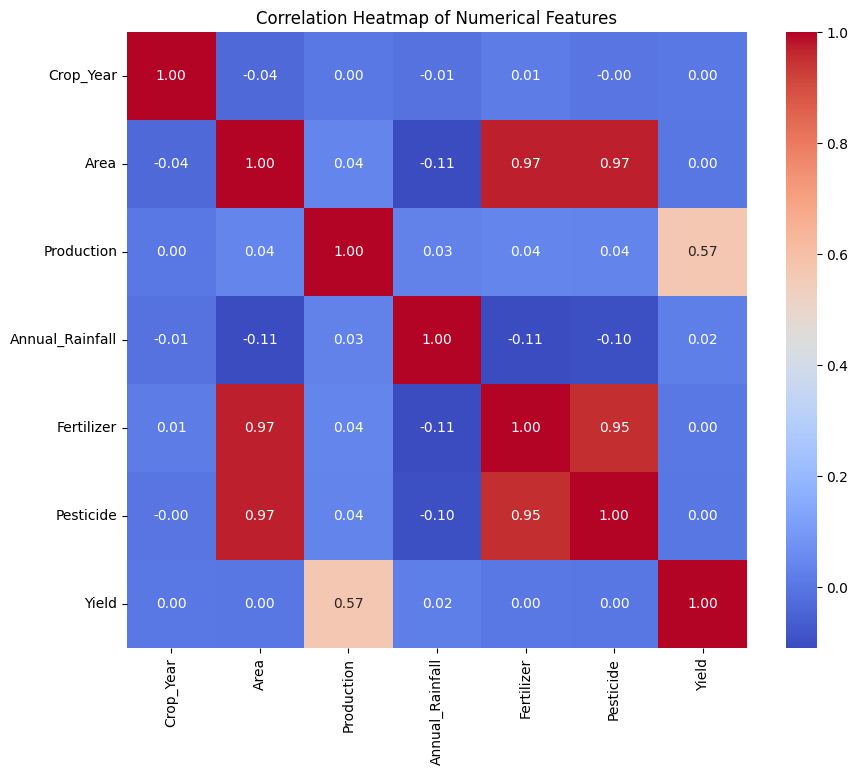

In [7]:
numerical_cols = ['Crop_Year', 'Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Distribution of Yield

# Boxplot: Yield by Season

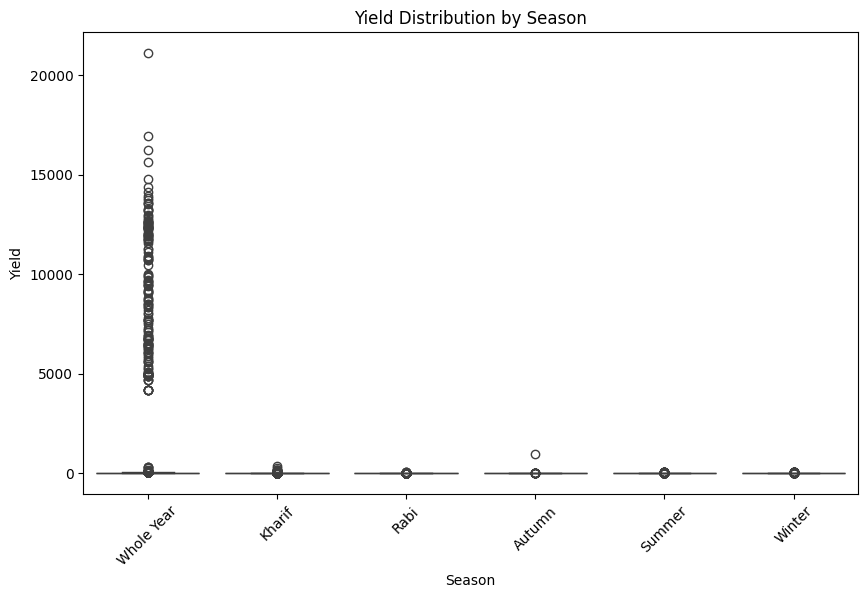

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='Yield', data=df)
plt.title('Yield Distribution by Season')
plt.xticks(rotation=45)
plt.show()


# Boxplot: Yield by State (top 10 states by data count)

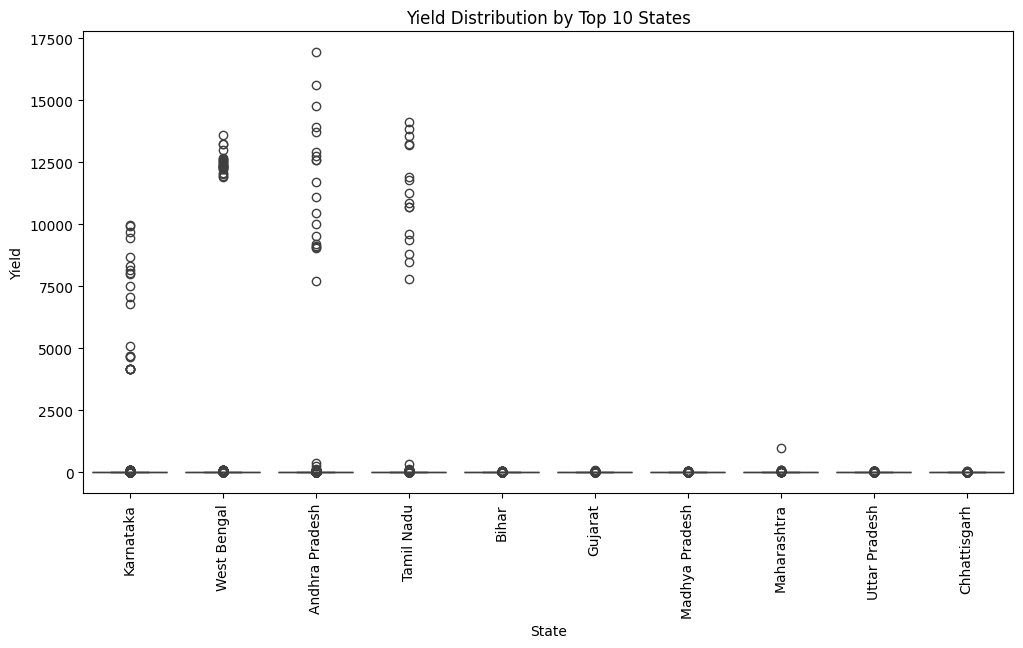

In [10]:
top_states = df['State'].value_counts().index[:10]
plt.figure(figsize=(12, 6))
sns.boxplot(x='State', y='Yield', data=df[df['State'].isin(top_states)])
plt.title('Yield Distribution by Top 10 States')
plt.xticks(rotation=90)
plt.show()

# Data Preprocessing

# Define crop categories

In [11]:
crop_categories = {
    'Cereals': [
        'Rice', 'Wheat', 'Maize', 'Jowar', 'Bajra', 'Ragi', 'Barley', 'Small millets', 'Other Cereals'
    ],
    'Pulses': [
        'Arhar/Tur', 'Gram', 'Moong', 'Urad', 'Masoor', 'Horse-gram', 'Peas & beans', 'Cowpea',
        'Other Rabi pulses', 'Other Kharif pulses', 'Other Summer Pulses', 'Khesari', 'Moong(Green Gram)', 'Peas & beans (Pulses)', 'Cowpea(Lobia)', 'Moth'
    ],
    'Oilseeds': [
        'Groundnut', 'Rapeseed & Mustard', 'Soyabean', 'Sunflower', 'Sesamum', 'Niger seed',
        'Castor seed', 'Linseed', 'Safflower', 'other oilseeds', 'Oilseeds total'
    ],
    'Commercial/Cash Crops': [
        'Cotton', 'Jute', 'Mesta', 'Sugarcane', 'Tobacco', 'Guar seed', 'Sannhamp', 'Cotton(lint)'
    ],
    'Spices & Condiments': [
        'Dry chillies', 'Turmeric', 'Coriander', 'Garlic', 'Ginger', 'Black pepper', 'Cardamom', 'Onion'
    ],
    'Fruits & Plantation Crops': [
        'Banana', 'Coconut', 'Arecanut', 'Cashewnut'
    ],
    'Tubers/Roots': [
        'Potato', 'Sweet potato', 'Tapioca'
    ]
}

# Encode categorical variables

In [12]:
def get_crop_category(crop):
    for category, crops in crop_categories.items():
        if crop in crops:
            return category
    return 'Other'

df['Category'] = df['Crop'].apply(get_crop_category)
# print("\nCrops not in defined categories (assigned to 'Other'):")
# print(df[df['Category'] == 'Other']['Crop'].unique())

In [13]:
label_encoders = {}
for col in ['Crop', 'Season', 'State', 'Category']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Data Spliting


In [14]:
train = df[df['Crop_Year'] <= 2012]
test = df[(df['Crop_Year'] > 2012) & (df['Crop_Year'] <= 2017)]
val = df[df['Crop_Year'] > 2017]

print(f"\nTrain Set (1997-2012): {train.shape[0]} rows")
print(f"Test Set (2013-2017): {test.shape[0]} rows")
print(f"Validation Set (2018+): {val.shape[0]} rows")


Train Set (1997-2012): 12399 rows
Test Set (2013-2017): 5011 rows
Validation Set (2018+): 2163 rows


# Features and target

In [15]:
features = ['Crop', 'Crop_Year', 'Season', 'State', 'Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']
X_train = train[features]
y_train = train['Yield']
X_test = test[features]
y_test = test['Yield']
X_val = val[features] if not val.empty else pd.DataFrame()
y_val = val['Yield'] if not val.empty else pd.Series()

# Scaling features

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
if not val.empty:
    X_val_scaled = scaler.transform(X_val)

In [17]:
tscv = TimeSeriesSplit(n_splits=5)

def evaluate_model(model, X, y, model_name, set_name="Test"):
    if len(y) == 0:
        print(f"No data for {set_name} evaluation.")
        return np.inf, -np.inf
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"{model_name} on {set_name} - MSE: {mse:.4f}, R²: {r2:.4f}")
    return mse, r2

In [18]:
# Decision Tree
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_param_grid, cv=tscv, scoring='r2', n_jobs=-1)
dt_grid.fit(X_train_scaled, y_train)
dt_best = dt_grid.best_estimator_
dt_test_mse, dt_test_r2 = evaluate_model(dt_best, X_test_scaled, y_test, "Decision Tree")
dt_cv_scores = cross_val_score(dt_best, X_train_scaled, y_train, cv=tscv, scoring='r2')
print(f"Decision Tree CV R²: {dt_cv_scores.mean():.4f} ± {dt_cv_scores.std():.4f}")

Decision Tree on Test - MSE: 37884.6059, R²: 0.9585
Decision Tree CV R²: 0.9735 ± 0.0414


In [19]:
# Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=tscv, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_
rf_test_mse, rf_test_r2 = evaluate_model(rf_best, X_test_scaled, y_test, "Random Forest")
rf_cv_scores = cross_val_score(rf_best, X_train_scaled, y_train, cv=tscv, scoring='r2')
print(f"Random Forest CV R²: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

Random Forest on Test - MSE: 34432.7825, R²: 0.9623
Random Forest CV R²: 0.9723 ± 0.0327


In [20]:
# SVR
svr_param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}
svr_grid = GridSearchCV(SVR(), svr_param_grid, cv=tscv, scoring='r2', n_jobs=-1)
svr_grid.fit(X_train_scaled, y_train)
svr_best = svr_grid.best_estimator_
svr_test_mse, svr_test_r2 = evaluate_model(svr_best, X_test_scaled, y_test, "SVR")
svr_cv_scores = cross_val_score(svr_best, X_train_scaled, y_train, cv=tscv, scoring='r2')
print(f"SVR CV R²: {svr_cv_scores.mean():.4f} ± {svr_cv_scores.std():.4f}")

SVR on Test - MSE: 920416.2802, R²: -0.0076
SVR CV R²: -0.0050 ± 0.0064


In [21]:
# Bayesian Optimization for Random Forest
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)
    }
    model = RandomForestRegressor(**params, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring='r2')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)
rf_optuna_best = study.best_params
rf_optuna_model = RandomForestRegressor(**rf_optuna_best, random_state=42)
rf_optuna_model.fit(X_train_scaled, y_train)
rf_opt_test_mse, rf_opt_test_r2 = evaluate_model(rf_optuna_model, X_test_scaled, y_test, "Random Forest (Optuna)")
rf_opt_cv_scores = cross_val_score(rf_optuna_model, X_train_scaled, y_train, cv=tscv, scoring='r2')
print(f"Random Forest (Optuna) CV R²: {rf_opt_cv_scores.mean():.4f} ± {rf_opt_cv_scores.std():.4f}")


[I 2025-09-06 05:09:28,871] A new study created in memory with name: no-name-619824b0-9482-4b95-a6b7-7338195ac342
[I 2025-09-06 05:10:17,891] Trial 0 finished with value: 0.9693431061997997 and parameters: {'n_estimators': 194, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9693431061997997.
[I 2025-09-06 05:10:36,999] Trial 1 finished with value: 0.9708690383168996 and parameters: {'n_estimators': 84, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9708690383168996.
[I 2025-09-06 05:10:55,046] Trial 2 finished with value: 0.9705851841515332 and parameters: {'n_estimators': 82, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9708690383168996.
[I 2025-09-06 05:11:20,896] Trial 3 finished with value: 0.9694453778400561 and parameters: {'n_estimators': 159, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 

Random Forest (Optuna) on Test - MSE: 38407.2478, R²: 0.9580
Random Forest (Optuna) CV R²: 0.9729 ± 0.0339


In [22]:
# Select best model
models = {'Decision Tree': dt_test_r2, 'Random Forest': rf_test_r2, 'SVR': svr_test_r2, 'Random Forest (Optuna)': rf_opt_test_r2}
best_model_name = max(models, key=models.get)
best_model = {
    'Decision Tree': dt_best,
    'Random Forest': rf_best,
    'SVR': svr_best,
    'Random Forest (Optuna)': rf_optuna_model
}[best_model_name]
print(f"\nBest Model: {best_model_name} with Test R²: {models[best_model_name]:.4f}")


Best Model: Random Forest with Test R²: 0.9623


Random Forest on Validation - MSE: 31792.1917, R²: 0.9562


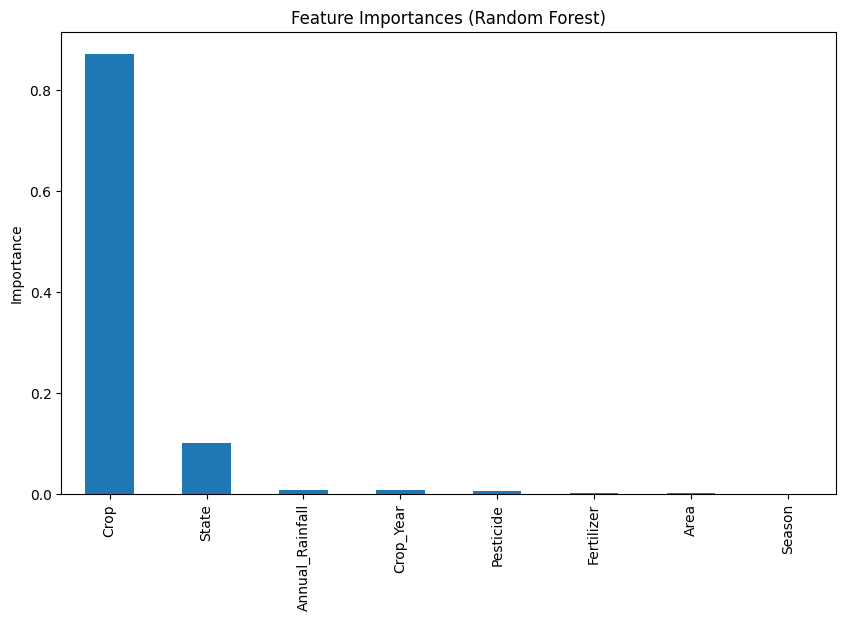

In [23]:
# Evaluate on validation set
if not val.empty:
    evaluate_model(best_model, X_val_scaled, y_val, best_model_name, "Validation")

# Feature importance
if best_model_name in ['Random Forest', 'Random Forest (Optuna)', 'Decision Tree']:
    importances = pd.Series(best_model.feature_importances_, index=features)
    plt.figure(figsize=(10, 6))
    importances.sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Feature Importances ({best_model_name})')
    plt.ylabel('Importance')
    plt.show()


# Recommend Best Crop per Category for Each State

In [24]:
# Reload original for string labels
df_original = pd.read_csv('crop_yield.csv')
df_original['Category'] = df_original['Crop'].apply(get_crop_category)
df_original = df_original.sort_values('Crop_Year')
past_data = df_original[df_original['Crop_Year'] <= 2017]
val_original = df_original[df_original['Crop_Year'] > 2017]

def recommend_best_crop_by_category(state_name, model, scaler, past_state_df, val_state_df, categories):
    results = []
    state_code = label_encoders['State'].transform([state_name])[0]

    if past_state_df.empty or val_state_df.empty:
        for category in categories:
            results.append({
                'State': state_name,
                'Category': category,
                'Predicted Best Crop': 'No data',
                'Predicted Yield': 0,
                'Actual Best Crop': 'No data',
                'Actual Yield': 0,
                'Match': False
            })
        return results

    # Averages from past data
    avg_area = past_state_df['Area'].mean()
    avg_year = past_state_df['Crop_Year'].max()
    avg_rainfall = past_state_df['Annual_Rainfall'].mean()
    avg_fertilizer = past_state_df['Fertilizer'].mean()
    avg_pesticide = past_state_df['Pesticide'].mean()
    most_common_season = past_state_df['Season'].mode()[0] if not past_state_df['Season'].mode().empty else 'Kharif'
    season_code = label_encoders['Season'].transform([most_common_season])[0]

    for category in categories:
        try:
            # Get crops in this category
            category_crops = [crop for crop in past_state_df[past_state_df['Category'] == category]['Crop'].unique() if crop in df_original['Crop'].unique()]
            if not category_crops:
                results.append({
                    'State': state_name,
                    'Category': category,
                    'Predicted Best Crop': 'No crops',
                    'Predicted Yield': 0,
                    'Actual Best Crop': 'No crops',
                    'Actual Yield': 0,
                    'Match': False
                })
                continue

            # Predict yields
            predictions = {}
            for crop_name in category_crops:
                crop_code = label_encoders['Crop'].transform([crop_name])[0]
                input_data = np.array([[crop_code, avg_year, season_code, state_code, avg_area, avg_rainfall, avg_fertilizer, avg_pesticide]])
                input_scaled = scaler.transform(input_data)
                predicted_yield = model.predict(input_scaled)[0]
                predictions[crop_name] = predicted_yield

            predicted_best = max(predictions, key=predictions.get) if predictions else 'No crops'
            predicted_yield = predictions.get(predicted_best, 0)

            # Actual best crop
            val_category_df = val_state_df[val_state_df['Category'] == category]
            actual_yields = val_category_df.groupby('Crop')['Yield'].mean()
            actual_best = actual_yields.idxmax() if not actual_yields.empty else 'No crops'
            actual_yield = actual_yields.max() if not actual_yields.empty else 0
            match = predicted_best == actual_best and predicted_best != 'No crops'

            results.append({
                'State': state_name,
                'Category': category,
                'Predicted Best Crop': predicted_best,
                'Predicted Yield': predicted_yield,
                'Actual Best Crop': actual_best,
                'Actual Yield': actual_yield,
                'Match': match
            })
        except Exception as e:
            results.append({
                'State': state_name,
                'Category': category,
                'Predicted Best Crop': f'Error: {str(e)}',
                'Predicted Yield': 0,
                'Actual Best Crop': 'Error',
                'Actual Yield': 0,
                'Match': False
            })

    return results



In [25]:
# Get recommendations
print("\nBest Crop Recommendations by Category for Each State (2018+):")
unique_states = df_original['State'].unique()
categories = list(crop_categories.keys())
recommendations = []
matches_by_category = {cat: {'matches': 0, 'total': 0} for cat in categories}

for state in unique_states:
    past_state_df = past_data[past_data['State'] == state]
    val_state_df = val_original[val_original['State'] == state]
    state_results = recommend_best_crop_by_category(state, best_model, scaler, past_state_df, val_state_df, categories)
    recommendations.extend(state_results)

    for result in state_results:
        print(f"State: {state}, Category: {result['Category']}")
        print(f"  Predicted: {result['Predicted Best Crop']} (Yield: {result['Predicted Yield']:.2f})")
        print(f"  Actual: {result['Actual Best Crop']} (Yield: {result['Actual Yield']:.2f})")
        print(f"  Match: {result['Match']}")
        if val_state_df[val_state_df['Category'] == result['Category']].shape[0] > 0:
            matches_by_category[result['Category']]['total'] += 1
            if result['Match']:
                matches_by_category[result['Category']]['matches'] += 1

# Summary
print("\nMatch Rate by Category:")
for category, stats in matches_by_category.items():
    if stats['total'] > 0:
        match_rate = (stats['matches'] / stats['total'] * 100)
        print(f"{category}: {match_rate:.2f}% ({stats['matches']}/{stats['total']})")
    else:
        print(f"{category}: No validation data")

# Save to CSV
recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_csv('crop_recommendations_by_category.csv', index=False)
print("\nRecommendations saved to 'crop_recommendations_by_category.csv'")



Best Crop Recommendations by Category for Each State (2018+):
State: Assam, Category: Cereals
  Predicted: Rice (Yield: 1.79)
  Actual: Maize (Yield: 3.01)
  Match: False
State: Assam, Category: Pulses
  Predicted: Peas & beans (Pulses) (Yield: 6.89)
  Actual: Peas & beans (Pulses) (Yield: 0.98)
  Match: True
State: Assam, Category: Oilseeds
  Predicted: Castor seed (Yield: 14.16)
  Actual: Sesamum (Yield: 0.66)
  Match: False
State: Assam, Category: Commercial/Cash Crops
  Predicted: Sugarcane (Yield: 39.58)
  Actual: Sugarcane (Yield: 36.34)
  Match: True
State: Assam, Category: Spices & Condiments
  Predicted: Black pepper (Yield: 14.66)
  Actual: Ginger (Yield: 9.28)
  Match: False
State: Assam, Category: Fruits & Plantation Crops
  Predicted: Coconut (Yield: 6916.39)
  Actual: Coconut (Yield: 8123.49)
  Match: True
State: Assam, Category: Tubers/Roots
  Predicted: Sweet potato (Yield: 25.10)
  Actual: Tapioca (Yield: 8.91)
  Match: False
State: West Bengal, Category: Cereals
  Pr

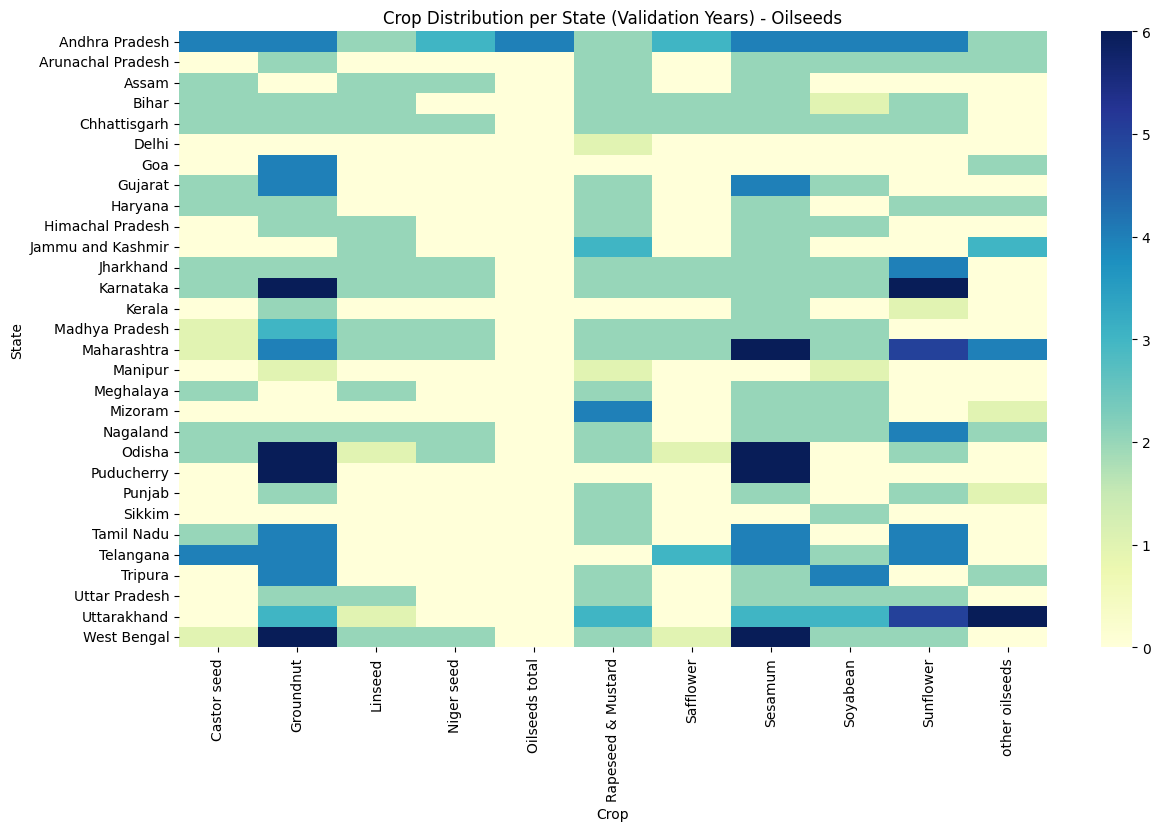


Best Crops per State in Validation Period (Oilseeds):
                   State                Crop      Yield
5483      Andhra Pradesh      other oilseeds  16.590909
16658  Arunachal Pradesh            Soyabean   1.499583
5897               Assam             Sesamum   0.661481
16068              Bihar           Sunflower   1.386500
16721       Chhattisgarh           Groundnut   1.490000
18353              Delhi  Rapeseed & Mustard   2.500000
5953                 Goa      other oilseeds   2.715000
16766            Gujarat           Groundnut   2.647813
16184            Haryana           Sunflower   2.092500
16854   Himachal Pradesh            Soyabean   1.631250
18367  Jammu and Kashmir             Linseed   1.213333
16863          Jharkhand           Groundnut   0.977917
5974           Karnataka           Groundnut   2.310000
5687              Kerala           Groundnut   1.280000
16259     Madhya Pradesh           Groundnut   1.476250
16928        Maharashtra           Groundnut   1.

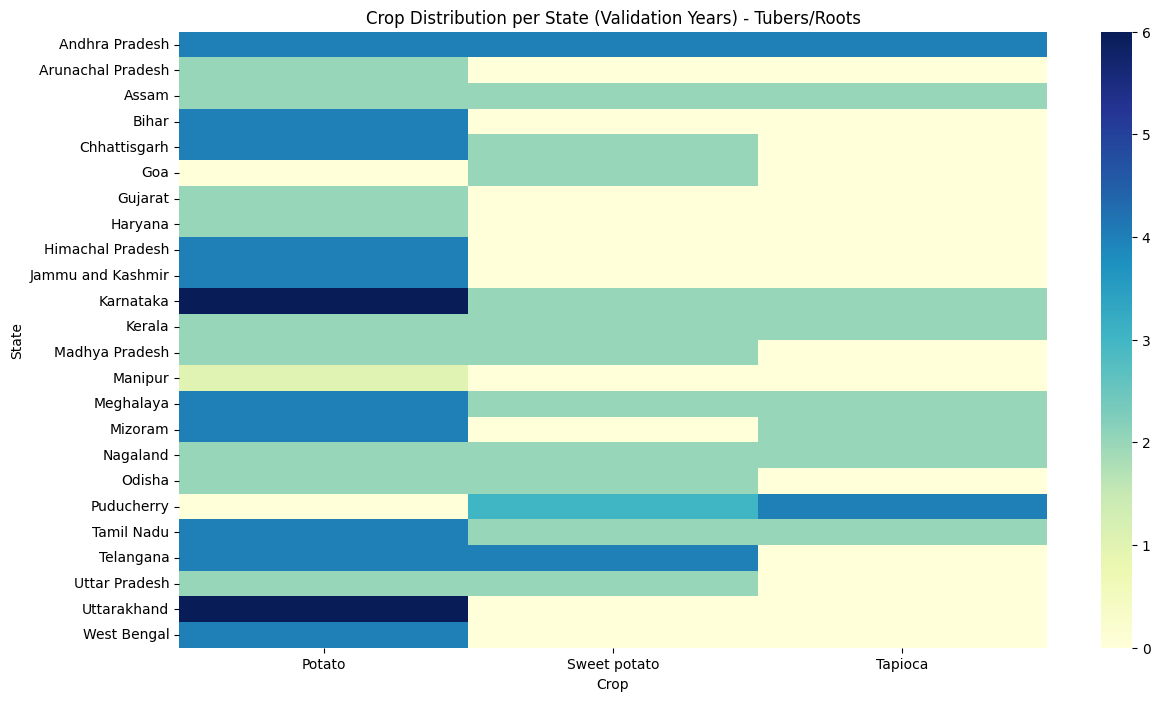


Best Crops per State in Validation Period (Tubers/Roots):
                   State          Crop      Yield
5475      Andhra Pradesh  Sweet potato  18.647778
16653  Arunachal Pradesh        Potato   6.802400
5901               Assam       Tapioca   8.910400
16057              Bihar        Potato  14.909444
16101       Chhattisgarh        Potato   7.005556
5952                 Goa  Sweet potato   2.530000
16782            Gujarat        Potato  29.248571
16179            Haryana        Potato  25.857273
16848   Himachal Pradesh        Potato  10.830000
18334  Jammu and Kashmir        Potato  13.186875
6014           Karnataka  Sweet potato  18.805185
6049              Kerala       Tapioca  41.951429
16909     Madhya Pradesh        Potato  21.801176
16337            Manipur        Potato   8.283333
5925           Meghalaya        Potato   8.257273
16365            Mizoram       Tapioca  11.022000
16405           Nagaland       Tapioca  20.264545
19665             Odisha        Potato  1

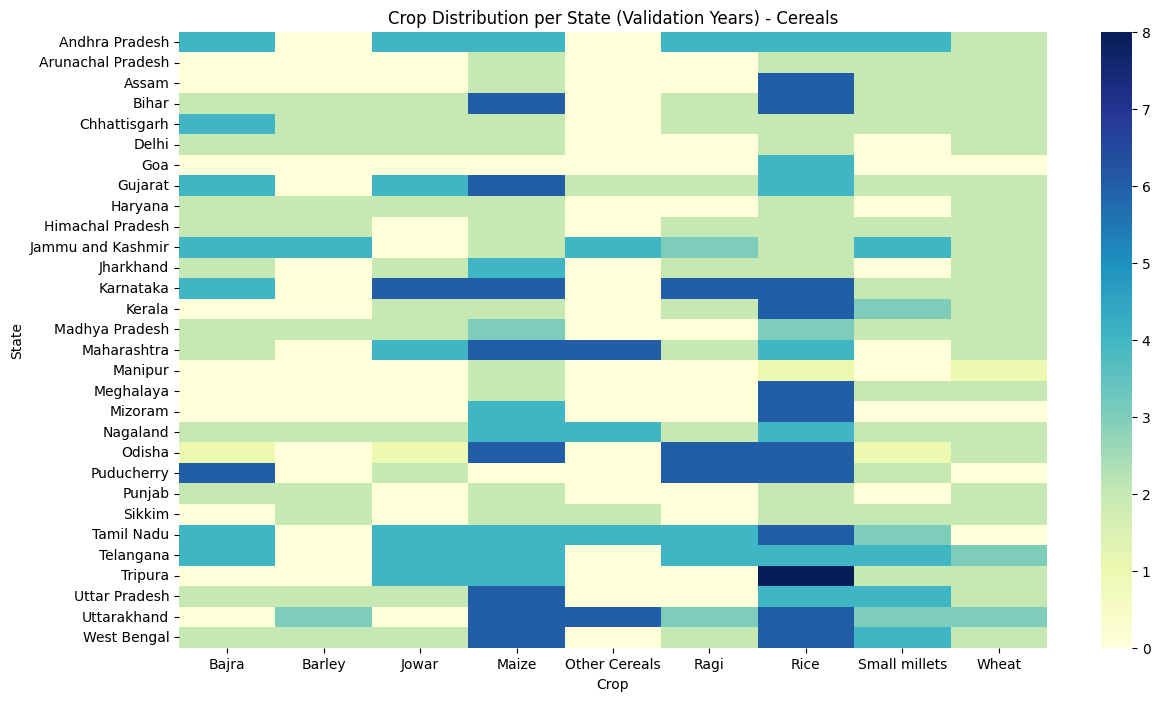


Best Crops per State in Validation Period (Cereals):
                   State           Crop      Yield
5791      Andhra Pradesh          Maize   6.698462
16664  Arunachal Pradesh          Wheat   2.168333
5884               Assam          Maize   3.155556
16681              Bihar          Maize   5.736562
16711       Chhattisgarh          Bajra  17.711739
18308              Delhi          Maize   5.100000
5950                 Goa           Rice   2.950000
16796            Gujarat          Wheat   3.143438
16187            Haryana          Wheat   4.825000
16839   Himachal Pradesh          Maize   2.630833
18376  Jammu and Kashmir  Other Cereals   4.394000
16877          Jharkhand           Rice   2.663333
5984           Karnataka          Maize   3.905357
5689              Kerala          Maize   4.508000
16922     Madhya Pradesh          Wheat   3.519423
16310        Maharashtra           Rice   2.755833
16344            Manipur          Wheat   2.395556
5929           Meghalaya    

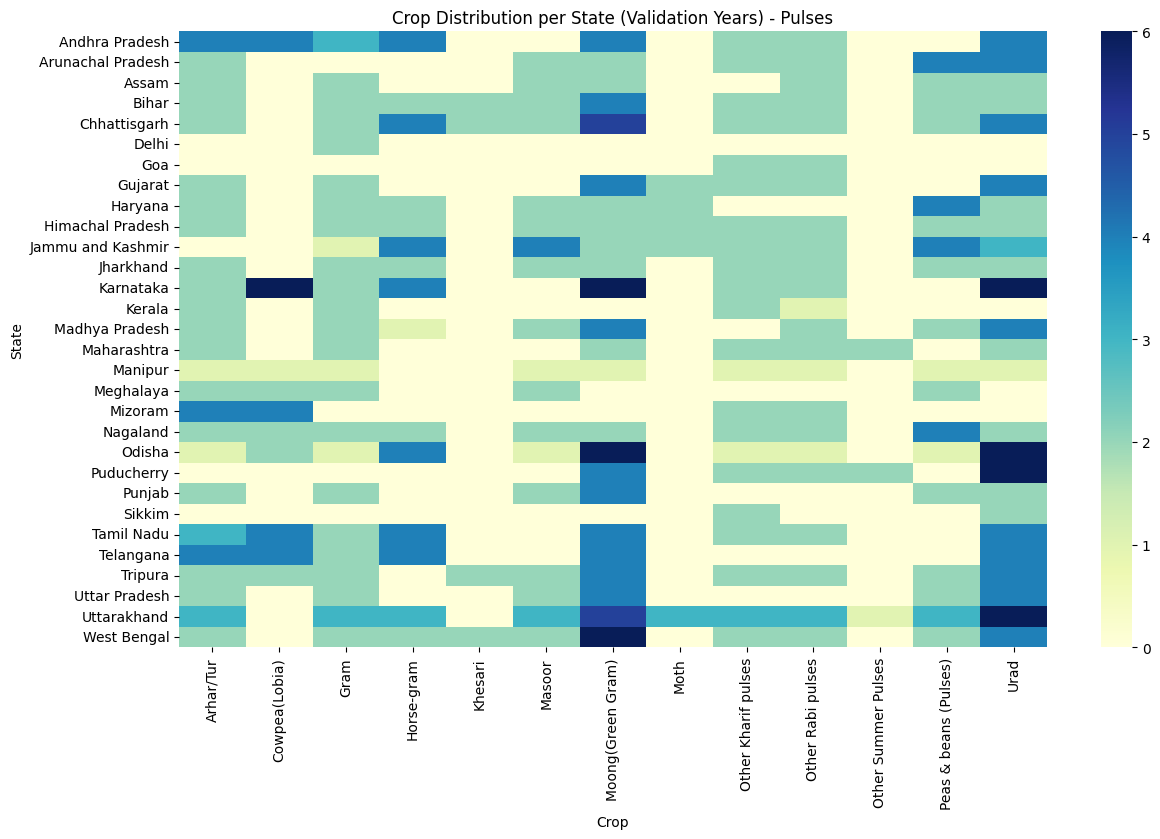


Best Crops per State in Validation Period (Pulses):
                   State                   Crop      Yield
5454      Andhra Pradesh      Other Rabi pulses   2.346667
16652  Arunachal Pradesh  Peas & beans (Pulses)   1.773333
5891               Assam  Peas & beans (Pulses)   1.035185
16031              Bihar              Arhar/Tur   1.898235
16083       Chhattisgarh                   Gram   1.016800
18306              Delhi                   Gram   2.000000
5601                 Goa      Other Rabi pulses   1.170000
16795            Gujarat                   Urad   1.580625
16815            Haryana  Peas & beans (Pulses)  13.101818
16844   Himachal Pradesh      Other Rabi pulses   4.000000
18379  Jammu and Kashmir  Peas & beans (Pulses)   4.504000
16874          Jharkhand  Peas & beans (Pulses)   1.232083
5993           Karnataka      Other Rabi pulses   0.855000
6037              Kerala    Other Kharif pulses   2.400000
16893     Madhya Pradesh                   Gram   1.626923
169

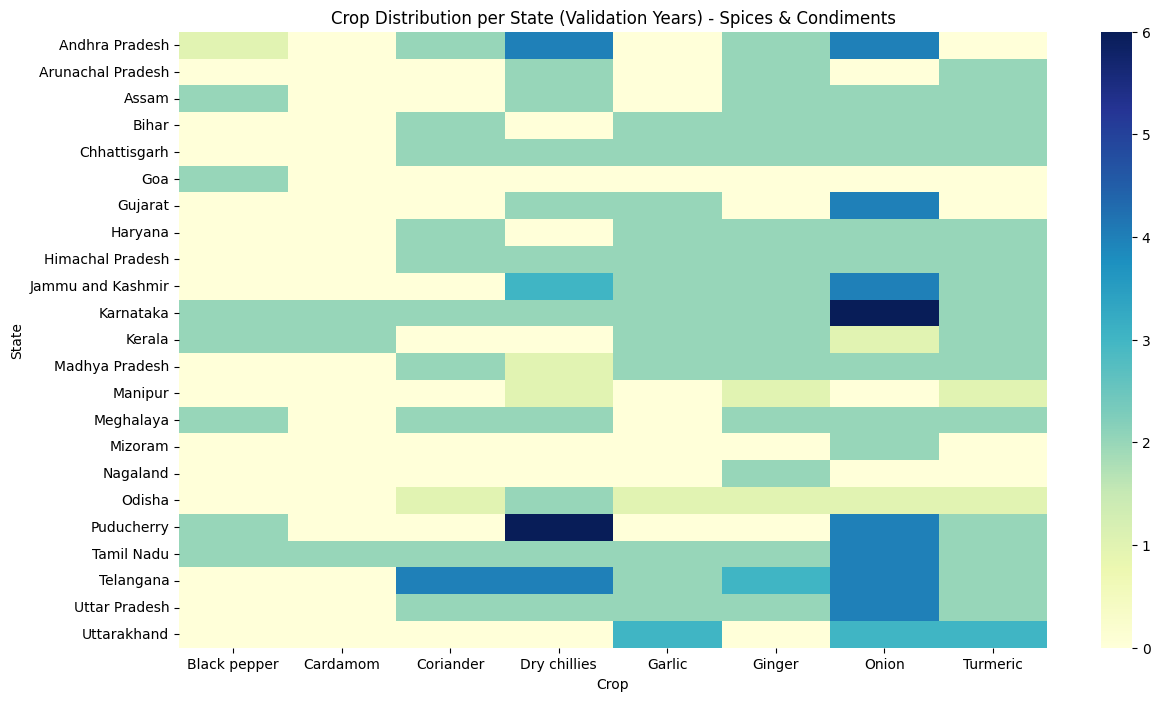


Best Crops per State in Validation Period (Spices & Condiments):
                   State          Crop       Yield
5452      Andhra Pradesh         Onion  247.572727
16009  Arunachal Pradesh        Ginger    6.178636
5880               Assam        Ginger    9.395185
16687              Bihar         Onion   12.605263
16097       Chhattisgarh         Onion    5.641818
5596                 Goa  Black pepper    0.405000
16777            Gujarat         Onion   28.892500
16176            Haryana         Onion   24.738636
16843   Himachal Pradesh         Onion    7.290000
18374  Jammu and Kashmir         Onion    2.426667
5625           Karnataka        Ginger   15.201034
6030              Kerala        Garlic    5.180000
16906     Madhya Pradesh         Onion   23.217451
16342            Manipur      Turmeric   12.485000
5916           Meghalaya        Ginger    9.668182
16352            Mizoram         Onion    4.292500
16373           Nagaland        Ginger    9.151818
17036           

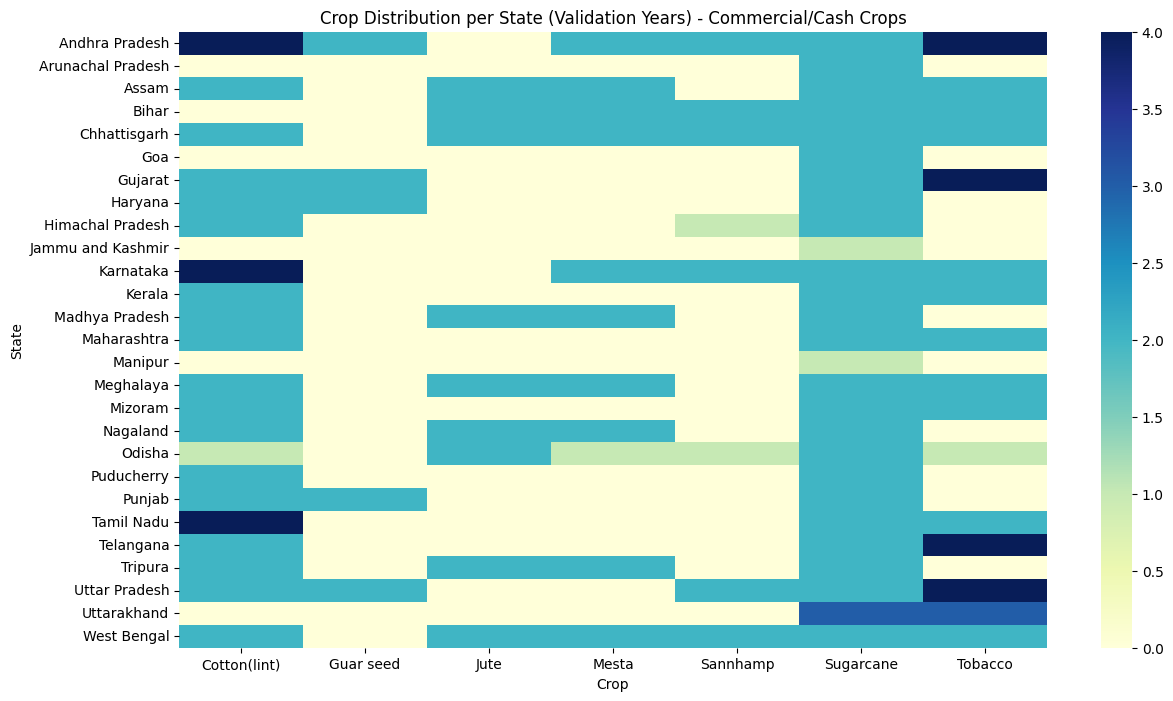


Best Crops per State in Validation Period (Commercial/Cash Crops):
                   State       Crop       Yield
5471      Andhra Pradesh  Sugarcane   84.047692
16659  Arunachal Pradesh  Sugarcane   23.747647
5899               Assam  Sugarcane   38.921111
16067              Bihar  Sugarcane   65.487813
16749       Chhattisgarh  Sugarcane   17.926667
5951                 Goa  Sugarcane   70.115000
16791            Gujarat  Sugarcane   70.570000
16821            Haryana  Sugarcane   78.944444
16218   Himachal Pradesh  Sugarcane   17.335000
18390  Jammu and Kashmir  Sugarcane    1.915000
5664           Karnataka  Sugarcane   83.268621
6046              Kerala  Sugarcane   83.834000
16917     Madhya Pradesh  Sugarcane   39.055102
16952        Maharashtra  Sugarcane   69.621481
16341            Manipur  Sugarcane   54.306667
5918           Meghalaya       Jute    9.946000
16981            Mizoram  Sugarcane   30.285714
16401           Nagaland  Sugarcane   43.501818
19676             Od

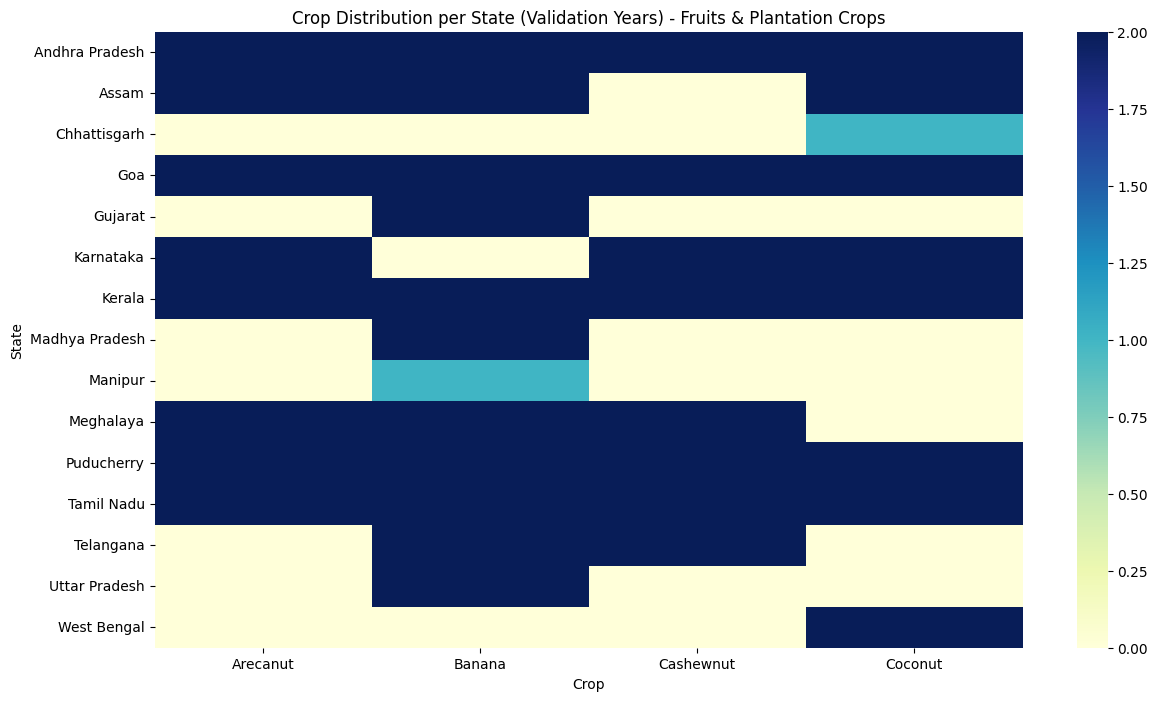


Best Crops per State in Validation Period (Fruits & Plantation Crops):
                State     Crop         Yield
5771   Andhra Pradesh  Coconut  16935.058460
5531            Assam  Coconut   8664.686667
16714    Chhattisgarh  Coconut      0.000000
5944              Goa  Coconut   6359.690000
16122         Gujarat   Banana     77.816250
5962        Karnataka  Coconut   8344.984000
5682           Kerala  Coconut   6426.820000
16250  Madhya Pradesh   Banana     48.048333
16324         Manipur   Banana     13.711111
5908        Meghalaya   Banana     10.730909
5838       Puducherry  Coconut   9474.625000
5714       Tamil Nadu  Coconut  11263.830000
16432       Telangana   Banana     61.471852
17194   Uttar Pradesh   Banana     46.335806
16598     West Bengal  Coconut  12018.407270


In [36]:
if not val_original.empty:
    for category in val_original["Category"].unique():
        cat_df = val_original[val_original["Category"] == category]

        if cat_df.empty:
            continue

        # Crosstab: states vs crops in this category
        heatmap_data = pd.crosstab(cat_df["State"], cat_df["Crop"])

        plt.figure(figsize=(14, 8))
        sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True)
        plt.title(f"Crop Distribution per State (Validation Years) - {category}")
        plt.ylabel("State")
        plt.xlabel("Crop")
        plt.show()

        # Print best crops for this category
        best_crops = cat_df.loc[cat_df.groupby("State")["Yield"].idxmax()]
        print(f"\nBest Crops per State in Validation Period ({category}):")
        print(best_crops[["State", "Crop", "Yield"]].sort_values("State"))
else:
    print("Validation set is empty. No heatmaps to show.")
